# CRITEO SPONSORED SEARCH CONVERSION LOG DATASET

## WHAT IS THIS NOTEBOOK ABOUT

This notebook presents EDA (Exploratory Data Analysis), elements of feature engineering and correlation test of the "CRITEO SPONSORED SEARCH CONVERSION LOG DATASET"

## CONTENTS

1. INTRODUCTION
2. EXPLORATORY DATA ANALYSIS
3. TESTING HYPOTHESES
4. FEATURE ENGINEERING
5. STATISTICAL TESTING OF DESCRIBING FEATURES
6. COMPETITION METRIC
7. SUMMARY
8. LITERATURE


# 1. INTRODUCTION

## DESCRIPTION OF THE DATASET

Criteo Sponsored Search Conversion Log Dataset contains logs obtained from Criteo Predictive Search. \
Each row in the dataset represents an action performed by the user on a product related advertisement. 

### Data description

- Sale : Indicates 1 if conversion occurred and 0 if not.
- SalesAmountInEuro : Indicates the revenue obtained when a conversion took place. This might be different from product-price, due to attribution issues. It is -1, when no conversion took place.
- Time_delay_for_conversion : This indicates the time between click and conversion. It is -1, when no conversion took place.

- click_timestamp: Timestamp of the click. The dataset is sorted according to timestamp.
- nb_clicks_1week: Number of clicks the product related advertisement has received in the last 1 week.
- product_price: Price of the product shown in the advertisement.
- product_age_group: The intended user age group of the user, the product is made for.
- device_type: This indicates whether it is a returning user or a new user on mobile, tablet or desktop. 
- audience_id:  We do not disclose the meaning of this feature.
- product_gender: The intended gender of the user, the product is made for.
- product_brand: Categorical feature about the brand of the product.
- product_category(1-7): Categorical features associated to the product. We do not disclose the meaning of these features.
- product_country: Country in which the product is sold.
- product_id: Unique identifier associated with every product.
- product_title: Hashed title of the product.
- partner_id: Unique identifier associated with the seller of the product.
- user_id: Unique identifier associated with every user.

**All categorical features have been hashed**, **-1 is the missing value indicator**

For more information about the dataset head over to https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/

## IMPORTS FOR THE NOTEBOOK

In [23]:
import os
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.5f}'.format

from scipy.stats import moment, skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline

## CONSTANTS
Constants that will be used later in the notebook

In [2]:
PARTNER_ID = 'BD01BAFAE73CF38C403978BBB458300C'

ALL_COLUMN_NAMES = ['Sale', 'SalesAmountInEuro', 'time_delay_for_conversion', 'click_timestamp',
                    'nb_clicks_1week', 'product_price', 'product_age_group', 'device_type',
                    'product_gender', 'product_brand','product_category(1)', 'product_category(2)',
                    'product_category(3)', 'product_category(4)','product_category(5)',
                    'product_category(6)', 'product_category(7)', 'product_country', 'product_id',
                    'product_title', 'partner_id', 'user_id']

OBJECT_TYPE_COLUMN_NAMES = ['product_age_group', 'device_type','audience_id', 'product_gender', 'product_brand',
                       'product_category(1)', 'product_category(2)', 'product_category(3)', 'product_category(4)',
                       'product_category(5)', 'product_category(6)', 'product_category(7)',
                       'product_country', 'product_id', 'product_title', 'user_id']

## CREATE CSV - CHOOSE THE PARTNER_ID

The analysis will be performed only for one of many *partner_id* from the dataset. Because the dataset can be considered a big data source, we have created a csv file containing only the information related to chosen ` PARTNER_ID `.

In [ ]:
%run create_csv_file.py

## READ CSV

In [3]:
filepath = f"CriteoSearchData_{PARTNER_ID}.csv"

if os.path.isfile(filepath):
    df_raw = pd.read_csv(f"CriteoSearchData_{PARTNER_ID}.csv", low_memory=False, usecols=ALL_COLUMN_NAMES)
else:
    print('Sorry. You have to create an appropriate csv file first.')

# drop partner_id column -> same for every row
df_raw.drop(labels='partner_id', inplace=True, axis=1)

Before performing EDA, let's preprocess the data - handle NaNs and hashed values.

First of all let's change all the `-1` values in the dataset to `np.NaN` to a indicate missing value.

## PREPROCESSING

In [6]:
# handle NANs
df_nans = df_raw.replace('-1', np.NaN)
df_nans.replace(-1, np.NaN, inplace=True)

# Filter Sales
df_nans_sale_1 = df_nans.query("Sale == 1")

Now let's handle the hashed values. First of all let's check datatypes of the columns of `df`

In [7]:
print(df_nans_sale_1.dtypes)
print('-'*30)
print(df_nans_sale_1.dtypes.value_counts())

Sale                           int64
SalesAmountInEuro            float64
time_delay_for_conversion    float64
click_timestamp                int64
nb_clicks_1week              float64
product_price                float64
product_age_group             object
device_type                   object
product_gender                object
product_brand                 object
product_category(1)           object
product_category(2)           object
product_category(3)           object
product_category(4)           object
product_category(5)           object
product_category(6)           object
product_category(7)          float64
product_country               object
product_id                    object
product_title                 object
user_id                       object
dtype: object
------------------------------
object     14
float64     5
int64       2
dtype: int64


Thanks to this summary we know now that 16 features have `object` type which means they have been hashed. We can simplify every column with `object` type. As long as they are hashed, we do not lose any valuable information (however we will store the original data in a dictionary `encoders`) and what is more - it will simplify the EDA of the dataset later. \
For example we will transform the `product_gender` column by assigning one number for each category. \
To achieve this we will use `LabelEncoder` from `sklearn.preprocessing` package.

In [37]:
df_nans_encoded = pd.DataFrame()
encoders = {}

for col in df_nans.columns:
    if col in OBJECT_TYPE_COLUMN_NAMES:
        encoder = LabelEncoder()
        # filter not null values from the column
        series_not_null = df_nans_sale_1[col][df_nans_sale_1[col].notnull()]
        # transform the values using LabelEncoder
        df_nans_encoded[col] = pd.Series(encoder.fit_transform(series_not_null), index=series_not_null.index)
        # save the encoder
        encoders[col] = encoder
    else:
        df_nans_encoded[col] = df_nans_sale_1[col]

df_nans_encoded.head(3)

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,product_gender,product_brand,...,product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,user_id
7,1,119.00000,457035.00000,1598898651,19.00000,119.00000,0.00000,1,0.00000,852.00000,...,3.00000,15.00000,NaN,NaN,NaN,NaN,0,1354,1412.00000,2347
12,1,53.00000,457.00000,1598919368,3.00000,53.00000,2.00000,0,0.00000,659.00000,...,13.00000,NaN,NaN,NaN,NaN,NaN,0,2179,804.00000,1520
35,1,178.00000,101671.00000,1598903859,0.00000,89.00000,0.00000,1,2.00000,396.00000,...,6.00000,27.00000,NaN,NaN,NaN,NaN,0,317,1010.00000,970


## CREATE FINAL DATASET

In [61]:
df_nans_encoded.click_timestamp = pd.to_datetime(df_nans_encoded.click_timestamp, unit='s', origin='unix')
df_nans_encoded['day'] = df_nans_encoded.click_timestamp.dt.date
df = df_nans_encoded.groupby(['day', 'product_id']).agg({'Sale' : 'size',
                                                         'SalesAmountInEuro': 'sum',
                                                         'time_delay_for_conversion': 'mean',
                                                         'nb_clicks_1week': 'mean',
                                                         'product_price': ['sum', 'mean'],
                                                         'product_age_group': 'mean', 
                                                         'device_type': 'mean', 
                                                         'product_gender': 'mean',
                                                         'product_brand': 'mean', 
                                                         'product_category(1)': 'mean', 
                                                         'product_category(2)': 'mean', 
                                                         'product_category(3)': 'mean', 
                                                         'product_category(4)': 'mean', 
                                                         'product_category(5)': 'mean', 
                                                         'product_category(6)': 'mean', 
                                                         'product_category(7)': 'mean', 
                                                         'product_country': 'mean', 
                                                         'product_title': 'mean'})

df.reset_index(inplace=True)
df.columns = ['_'.join(temp).strip('_') for temp in df.columns.to_flat_index()]
df['time_delay_minutes'] = df.time_delay_for_conversion_mean / 60
df['time_delay_hours'] = df.time_delay_minutes / 60
df['time_delay_days'] = df.time_delay_hours / 24
df.head(8)

,day,product_id,Sale_size,SalesAmountInEuro_sum,time_delay_for_conversion_mean,nb_clicks_1week_mean,product_price_sum,product_price_mean,product_age_group_mean,device_type_mean,...,product_category(3)_mean,product_category(4)_mean,product_category(5)_mean,product_category(6)_mean,product_category(7)_mean,product_country_mean,product_title_mean,time_delay_minutes,time_delay_hours,time_delay_days
0,2020-08-04,1068,2,580.00000,57369.00000,0.00000,290.00000,145.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,1895.00000,956.15000,15.93583,0.66399
1,2020-08-04,2326,2,228.00000,986.00000,0.00000,228.00000,114.00000,0.00000,1.00000,...,42.00000,NaN,NaN,NaN,NaN,0,583.00000,16.43333,0.27389,0.01141
2,2020-08-05,19,2,254.00000,105006.00000,3.00000,254.00000,127.00000,1.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,260.00000,1750.10000,29.16833,1.21535
3,2020-08-05,32,2,178.00000,479.00000,5.00000,178.00000,89.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,1038.00000,7.98333,0.13306,0.00554
4,2020-08-05,132,2,194.00000,479925.00000,1.00000,194.00000,97.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,211.00000,7998.75000,133.31250,5.55469
5,2020-08-05,580,2,380.00000,1643.00000,26.00000,380.00000,190.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,357.00000,27.38333,0.45639,0.01902
6,2020-08-05,682,2,250.00000,424.00000,0.00000,190.00000,95.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,0,1304.00000,7.06667,0.11778,0.00491
7,2020-08-05,734,2,300.00000,85069.00000,0.00000,152.00000,76.00000,0.00000,1.00000,...,15.00000,NaN,NaN,NaN,NaN,0,1328.00000,1417.81667,23.63028,0.98459


# 2. EXPLORATORY DATA ANALYSIS

This part of the notebook presents EDA performed on the FINAL DATASET created earlier. \
## Summary statistics
First of all we will calculate statistics for column `product_price_mean`

Summary statistics:
- Mean
- Median
- Variance
- Standard deviation
- Skewness
- Kurtosis
- 0.25, 0.5, 0.75 Quantiles
- IQR

In [64]:
price = df['SalesAmountInEuro_sum']

summary_statistics = pd.DataFrame({
    'product_price_mean': [price.mean(),
                          price.median(),
                          price.var(ddof=0),
                          price.std(ddof=0),
                          moment(price, 3)/(moment(price, 2)**(3/2)),
                          moment(price, 4)/(moment(price, 2))**2,
                          price.quantile(0.25),
                          price.quantile(0.5),
                          price.quantile(0.75),
                          price.quantile(0.75) - price.quantile(0.25)]},
    index=['mean', 'median', 'variance', 'std', 'skewness', 'kurtosis', '0.25', '0.5', '0.75', 'IQR'])

summary_statistics

,product_price_mean
mean,374.31416
median,220.00000
variance,290109.16247
std,538.61783
skewness,7.08279
kurtosis,86.39909
0.25,138.00000
0.5,220.00000
0.75,410.00000
IQR,272.00000


## Frequency

Frequency distribution table

## Histogram

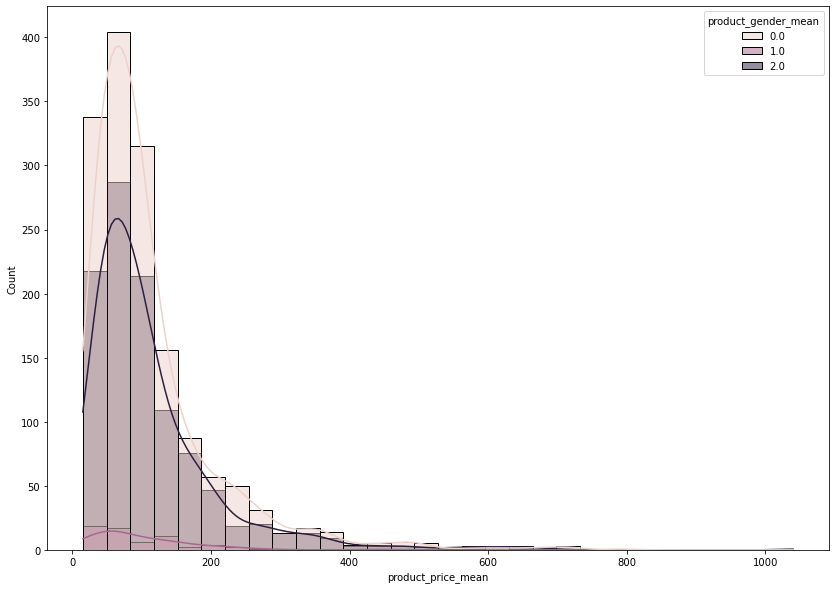

In [58]:
plt.figure(figsize=(14, 10))

sns.histplot(data=df, x='product_price_mean', bins=30, hue='product_gender_mean', kde=True)
plt.show()

## Box plot

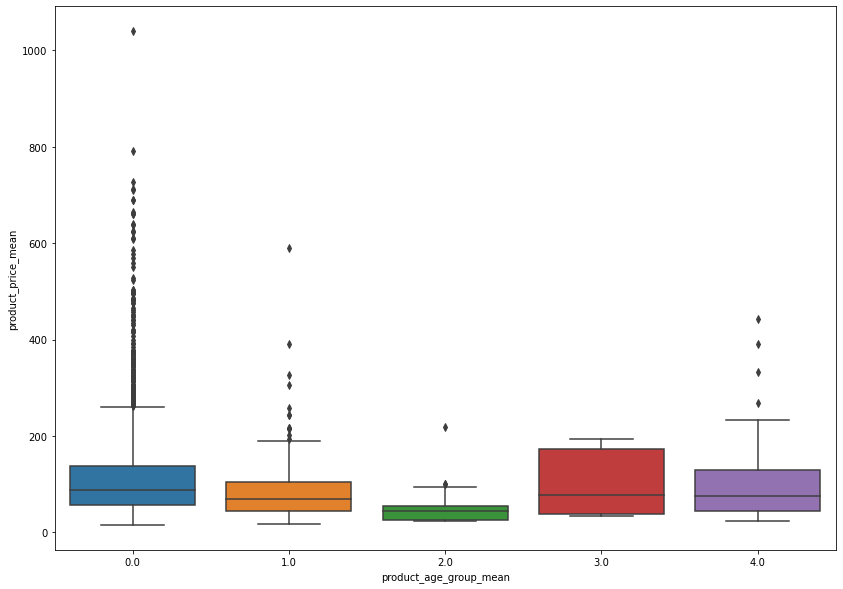

In [56]:
plt.figure(figsize=(14, 10))

sns.boxplot(x='product_age_group_mean', y='product_price_mean', data=df)
plt.show()

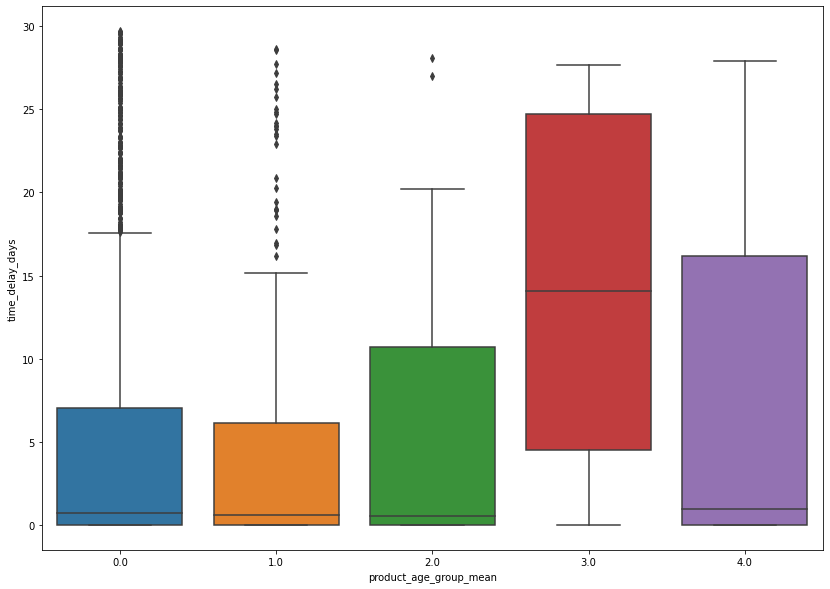

In [63]:
plt.figure(figsize=(14, 10))

sns.boxplot(x='product_age_group_mean', y='time_delay_days', data=df)
plt.show()

# 3. TESTING HYPOTHESES

# 4. FEATURE ENGINEERING

# 5. STATISTICAL TESTING OF DESCRIBING FEATURES

# 6. COMPETITION METRIC

# 7. SUMMARY